In [1]:
import pandas as pd

from oversampling_training.oversampling_multiclass import split_dataset, apply_smote_multiclass, train_random_forest_multiclass, train_svm_multiclass, train_lightgbm, rf_plot_confusion_matrices, svm_plot_confusion_matrices, lightgbm_plot_confusion_matrices
from features_extraction import features, exp1, exp2
from preprocessing.resample import resample_dataset

# CLASSIFICAZIONE MULTICLASSE

In [2]:
csv_file_path = 'C:/underwater-classification/resample_experiments/resampling_192000/binary/Malfante_resampled_192000_binary.csv'

### Resampling a 192000

In [3]:
resample_dataset(csv_file_path, 192000)

In [4]:
df = pd.read_csv(csv_file_path)

In [5]:
df.to_csv("Malfante_resampled_192000_multi.csv", index=False)

In [6]:
print("Distribuzione delle subclass prima dello split:")
print(df['Subclass'].value_counts())

Distribuzione delle subclass prima dello split:
Subclass
Passengership                 11728
Tanker                        11221
Tug                           10162
Cargo                          9671
Humpback Whale                 1523
                              ...  
Northern bottlenose whale         2
Australian Snubfin Dolphin        1
Pygmy Right Whale                 1
True_s beaked whale               1
Harbor porpoise                   1
Name: count, Length: 112, dtype: int64


In [7]:
df

,File Name,Class,Subclass,Spectral Centroid Mean,Spectral Bandwidth RMS,Standard Deviation,Skewness,Kurtosis,Shannon Entropy,Renyi Entropy,Rate of Attack,Rate of Decay,Threshold Crossings,Silence Ratio,Mean,Max Over Mean,Min Over Mean,Energy Measurements
0,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg1.wav,Non-Target,Ambient Noise,2365.986175,3626.559977,0.226857,0.290664,0.892111,4.971782,-5.535341,761.942857,0.001994,4632,0.611801,-0.034183,-21.465580,23.616245,0.052632
1,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg2.wav,Non-Target,Ambient Noise,2758.993889,3910.784244,0.108625,-0.005666,-0.569424,5.162490,-6.898327,740.150685,0.001977,4950,0.634804,-0.032954,-9.484909,10.162800,0.012885
2,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg3.wav,Non-Target,Ambient Noise,2129.882107,3525.266729,0.247894,-0.276424,0.685545,4.945784,-5.216692,741.959459,0.001981,2836,0.576946,-0.030722,-25.107834,32.549988,0.062395
3,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg4.wav,Non-Target,Ambient Noise,2578.399075,3808.768181,0.156887,0.579541,1.394189,4.977093,-6.244174,741.291139,0.001975,3886,0.676697,-0.033154,-17.874725,14.261857,0.025713
4,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg5.wav,Non-Target,Ambient Noise,2397.596769,3693.559388,0.182233,-0.088012,-0.083008,5.107721,-5.867613,760.642857,0.001995,4144,0.588086,-0.031111,-16.117334,20.706032,0.034177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50988,ship_small_seg5.wav,Target,Vessel,454.204379,1544.897321,0.194803,0.013843,0.040826,4.912185,-5.505466,747.387500,0.002098,3257,0.502537,0.010867,67.361890,-71.922520,0.038066
50989,ship_small_seg6.wav,Target,Vessel,451.849415,1558.023055,0.187102,0.015866,0.072826,4.923655,-5.597261,747.362500,0.002021,3284,0.500046,0.010350,69.048370,-69.847420,0.035114
50990,ship_small_seg7.wav,Target,Vessel,450.678766,1588.301112,0.179071,0.000758,0.094914,4.904687,-5.670881,747.387500,0.001921,3248,0.500486,0.011119,60.423195,-65.621540,0.032190
50991,ship_small_seg8.wav,Target,Vessel,451.362679,1547.605982,0.188441,-0.002944,0.136705,4.846846,-5.513505,747.362500,0.002026,3283,0.495906,0.010434,77.097830,-72.660736,0.035619


### Filtro dataframe

In [8]:
df['File Name'] = df['File Name'].str[:-4]
df = df[df['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df['Parent'] = df['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df = df[df['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


## SPLIT

In [9]:
X_train_imputed, X_val_imputed, X_test_imputed, y_train_encoded, y_val_encoded, y_test_encoded, subclass_encoder = split_dataset(df)


Dimensione del set di addestramento: 33872 campioni (78.61%)
Dimensione del set di validazione: 4403 campioni (10.22%)
Dimensione del set di test: 4814 campioni (11.17%)

Distribuzione delle subclass nel set di addestramento:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64


In [10]:
X_train_imputed[['File Name', 'Parent', 'Subclass']].groupby(['Parent', 'File Name']).describe()

Subclass  \
                                                                                   count   
Parent                               File Name                                             
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1         1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13        1   
...                                                                                  ...   
ship_small                           ship_small_seg5                                   1   
                                     ship_small_seg6                                   1   
                                     ship_small_seg7                                   1   
                                     ship_small_seg8                                   1   
                                     ship_small_seg9                                   1   

                                                                                        \
                                                                                unique   
Parent                               File Name                                           
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1       1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13      1   
...                                                                                ...   
ship_small                           ship_small_seg5                                 1   
                                     ship_small_seg6                                 1   
                                     ship_small_seg7                                 1   
                                     ship_small_seg8                                 1   
                                     ship_small_seg9                                 1   

                                                                                                \
                                                                                           top   
Parent                               File Name                                                   
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1   Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13  Passengership   
...                                                                                        ...   
ship_small                           ship_small_seg5                                    Vessel   
                                     ship_small_seg6                                    Vessel   
                                     ship_small_seg7                                    Vessel   
                                     ship_small_seg8                                    Vessel   
                                     ship_small_seg9                                    Vessel   

                                                                                      
                                                                      

In [11]:
X_test_imputed[['File Name', 'Parent','Subclass']].groupby(['Parent', 'File Name']).describe()

Subclass  \
                                                                                                    count   
Parent                                        File Name                                                     
20160516a-9_9                                 20160516a-9_9_seg1                                        1   
                                              20160516a-9_9_seg2                                        1   
                                              20160516a-9_9_seg3                                        1   
20160616b-21_200904                           20160616b-21_200904_seg1                                  1   
                                              20160616b-21_200904_seg10                                 1   
...                                                                                                   ...   
SanctSound_GR01_01_vessel_20181217T204109Z    SanctSound_GR01_01_vessel_20181217T204109Z_seg2           1   
SanctSound_HI04_02_smallboat_20191211T175807Z SanctSound_HI04_02_smallboat_20191211T175807Z_seg1        1   
                                              SanctSound_HI04_02_smallboat_20191211T175807Z_seg2        1   
SanctSound_SB03_09_vessel_20200415T161235Z    SanctSound_SB03_09_vessel_20200415T161235Z_seg1           1   
                                              SanctSound_SB03_09_vessel_20200415T161235Z_seg2           1   

                                                                                                         \
                                                                                                 unique   
Parent                                        File Name                                                   
20160516a-9_9                                 20160516a-9_9_seg1                                      1   
                                              20160516a-9_9_seg2                                      1   
                                              20160516a-9_9_seg3                                      1   
20160616b-21_200904                           20160616b-21_200904_seg1                                1   
                                              20160616b-21_200904_seg10                               1   
...                                                                                                 ...   
SanctSound_GR01_01_vessel_20181217T204109Z    SanctSound_GR01_01_vessel_20181217T204109Z_seg2         1   
SanctSound_HI04_02_smallboat_20191211T175807Z SanctSound_HI04_02_smallboat_20191211T175807Z_seg1      1   
                                              SanctSound_HI04_02_smallboat_20191211T175807Z_seg2      1   
SanctSound_SB03_09_vessel_20200415T161235Z    SanctSound_SB03_09_vessel_20200415T161235Z_seg1         1   
                                              SanctSound_SB03_09_vessel_20200415T161235Z_seg2         1   

                                                                                                                 \
                                                                                                            top   
Parent                                        File Name                                                           
20160516a-9_9                                 20160516a-9_9_seg1                                  Passengership   
                                              20160516a-9_9_seg2                                  Passengership   
                                              20160516a-9_9_seg3                                  Passengership   
20160616b-21_200904                           20160616b-21_200904_seg1                            Passengership   
                                              20160616b-21_200904_seg10                           Passengership   
...                                                                                                         ...   
SanctSound_GR01_01_vessel_20181217T2

In [12]:
X_val_imputed[['File Name', 'Parent','Subclass']].groupby(['Parent', 'File Name']).describe()


Subclass  \
                                                                                          count   
Parent                                   File Name                                                
20160531-7_142749                        20160531-7_142749_seg1                               1   
                                         20160531-7_142749_seg10                              1   
                                         20160531-7_142749_seg100                             1   
                                         20160531-7_142749_seg101                             1   
                                         20160531-7_142749_seg102                             1   
...                                                                                         ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg9        1   

                                                                                               \
                                                                                       unique   
Parent                                   File Name                                              
20160531-7_142749                        20160531-7_142749_seg1                             1   
                                         20160531-7_142749_seg10                            1   
                                         20160531-7_142749_seg100                           1   
                                         20160531-7_142749_seg101                           1   
                                         20160531-7_142749_seg102                           1   
...                                                                                       ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg9      1   

                                                                                                \
                                                                                           top   
Parent                                   File Name                                               
20160531-7_142749                        20160531-7_142749_seg1                         Tanker   
                                         20160531-7_142749_seg10                        Tanker   
                                         20160531-7_142749_seg100                       Tanker   
                                         20160531-7_142749_seg101                       Tanker   
                                         20160531-7_142749_seg102                       Tanker   
...                                                                                        ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8  Vessel   
                                         SanctSound_OC02_01_ship_20

## SMOTE

In [13]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Adatta questo valore al numero di core che desideri utilizzare

In [14]:
X_train_resampled, y_train_resampled = apply_smote_multiclass(X_train_imputed, y_train_encoded, 1)

Distribuzione delle classi nel set di training dopo SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


In [15]:
print(pd.Series(subclass_encoder.inverse_transform(y_train_resampled)).value_counts())

Passengership    8830
Tanker           8830
Cargo            8830
Tug              8830
Vessel           8830
Name: count, dtype: int64


In [16]:
print(f"\nDistribuzione delle classi nel set di validation:\n \n{pd.Series(y_val_encoded).value_counts()} ")


Distribuzione delle classi nel set di validation:
 
1    1291
2    1276
3     956
0     862
4      18
Name: count, dtype: int64 


In [17]:

print(f"\nDistribuzione delle classi nel set di test:\n \n{pd.Series(y_test_encoded).value_counts()} ")


Distribuzione delle classi nel set di test:
 
1    1607
2    1201
0    1007
3     993
4       6
Name: count, dtype: int64 


In [18]:
# Stampare le forme dei dataset
print("\nForme dei dataset:")
print(f"Train: {X_train_imputed.shape}") #validation
print(f"Validation: {X_val_imputed.shape}") #validation
print(f"Test: {X_test_imputed.shape}") #test
print(f"Train bilanciato e filtrato: {X_train_resampled.shape}") #train dopo SMOTE


Forme dei dataset:
Train: (33872, 19)
Validation: (4403, 19)
Test: (4814, 19)
Train bilanciato e filtrato: (44150, 15)


# Esperimento 1 

Esperimento effettuato prendendo come riferimento alcune features numeriche da "Malfante et al."

In [19]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed = X_val_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed = X_test_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')


### 1.1 Random Forest Model

In [20]:
random_forest_model = train_random_forest_multiclass(X_train_resampled, y_train_resampled, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

Accuratezza sul Validation Set: 0.3961
Log Loss sul Validation Set: 1.3998

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.26      0.33      0.29       862
           1       0.50      0.33      0.39      1291
           2       0.46      0.40      0.43      1276
           3       0.39      0.53      0.45       956
           4       0.50      1.00      0.67        18

    accuracy                           0.40      4403
   macro avg       0.42      0.52      0.45      4403
weighted avg       0.42      0.40      0.40      4403

Accuratezza sul Test Set: 0.4063
Log Loss sul Test Set: 1.3201

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.37      0.37      0.37      1007
           1       0.40      0.21      0.27      1607
           2       0.47      0.48      0.48      1201
           3       0.39      0.67      0.49       993
    

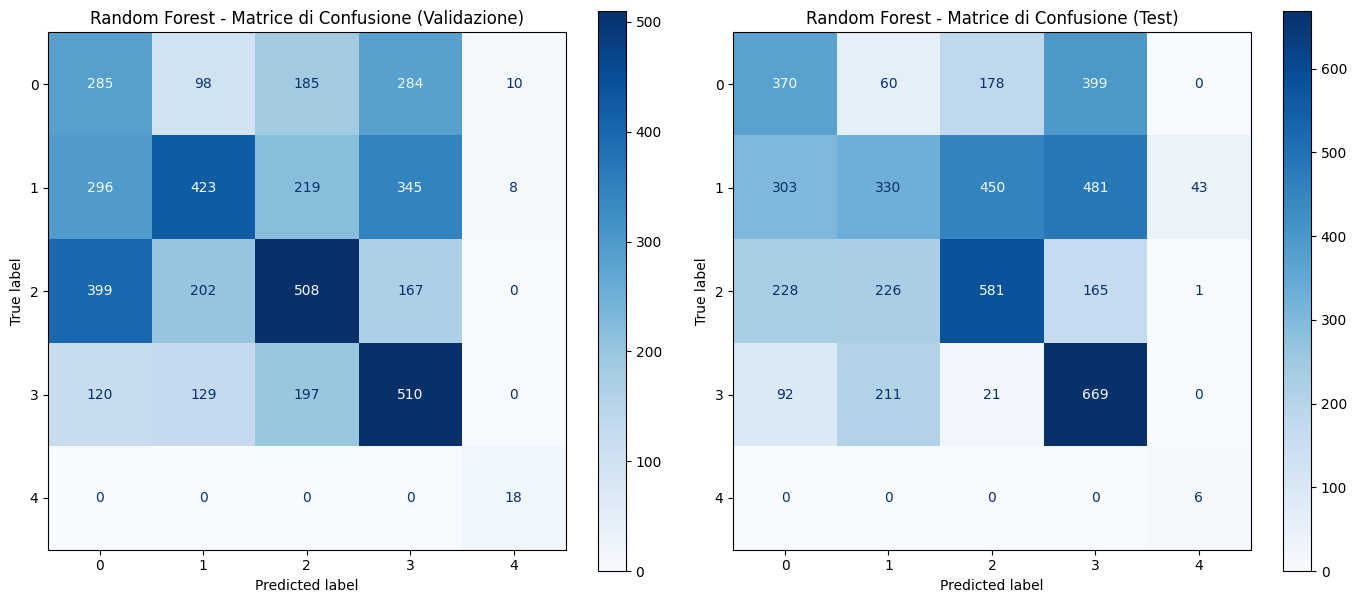

In [21]:
rf_plot_confusion_matrices(random_forest_model, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)


### 1.2 SVM Model

In [53]:
svm_model = train_svm_multiclass(X_train_resampled, y_train_resampled, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

Distribuzione delle classi reali nel set di validazione: [ 862 1291 1276  956   18]
Distribuzione delle classi predette nel set di validazione: [ 575  418  441 2807  162]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.18      0.12      0.14       862
           1       0.32      0.10      0.16      1291
           2       0.62      0.21      0.32      1276
           3       0.27      0.79      0.40       956
           4       0.11      1.00      0.20        18

    accuracy                           0.29      4403
   macro avg       0.30      0.45      0.24      4403
weighted avg       0.37      0.29      0.25      4403

Accuratezza sul set di validazione: 0.2914
Distribuzione delle classi reali nel set di test: [1007 1607 1201  993    6]
Distribuzione delle classi predette nel set di test: [ 410  567  725 2769  343]
Report di classificazione del set di test:
              precision    recall  f1-score   s

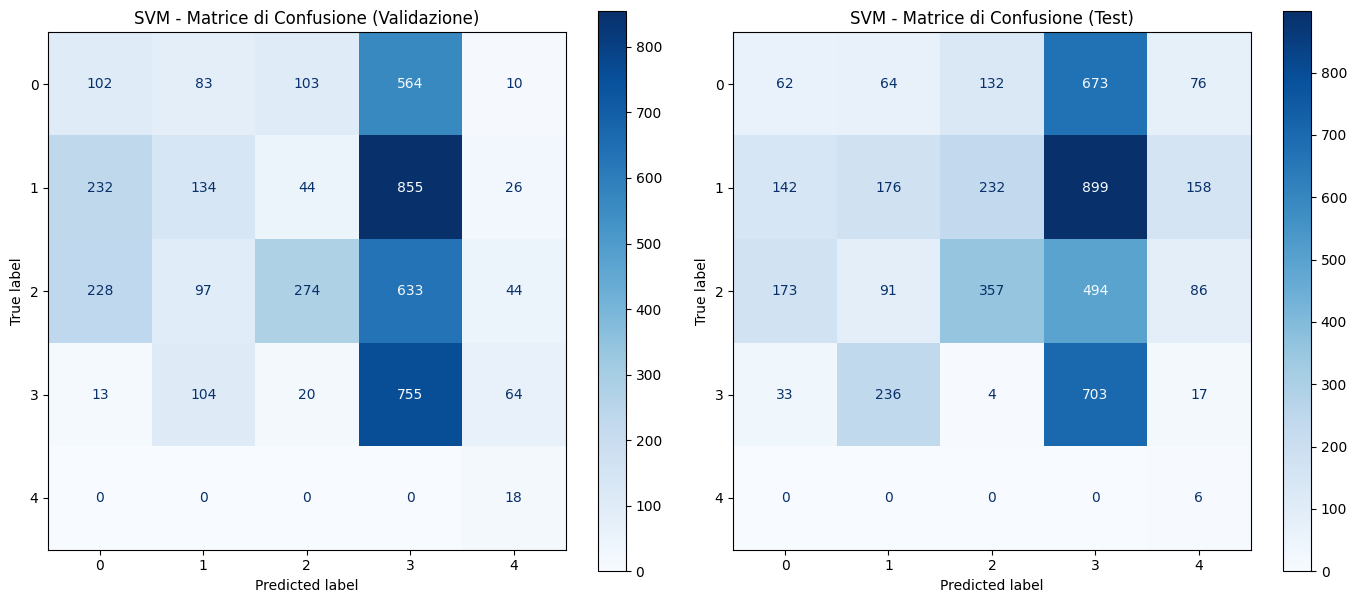

In [54]:
svm_plot_confusion_matrices(svm_model, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

### 1.3 LightGBM Model

In [24]:
lightgbm_model = train_lightgbm(X_train_resampled, y_train_resampled, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

Dimensioni dopo NaN nel set di addestramento: X_train: (44150, 15), y_train: (44150,)
Dimensioni dopo NaN nel set di validazione: X_val: (4403, 15), y_val: (4403,)
Dimensioni dopo NaN nel set di test: X_test: (4814, 15), y_test: (4814,)
Classi nel set di addestramento: [0 1 2 3 4]
Classi nel set di validazione: [0 1 2 3 4]
Classi nel set di test: [0 1 2 3 4]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.19      0.24      0.22       862
           1       0.48      0.39      0.43      1291
           2       0.37      0.39      0.38      1276
           3       0.51      0.46      0.48       956
           4       0.51      1.00      0.68        18

    accuracy                           0.38      4403
   macro avg       0.41      0.50      0.44      4403
weighted avg       0.40      0.38      0.39      4403

Accuratezza sul set di validazione: 0.3797
Report di classificazione del set di test:
              

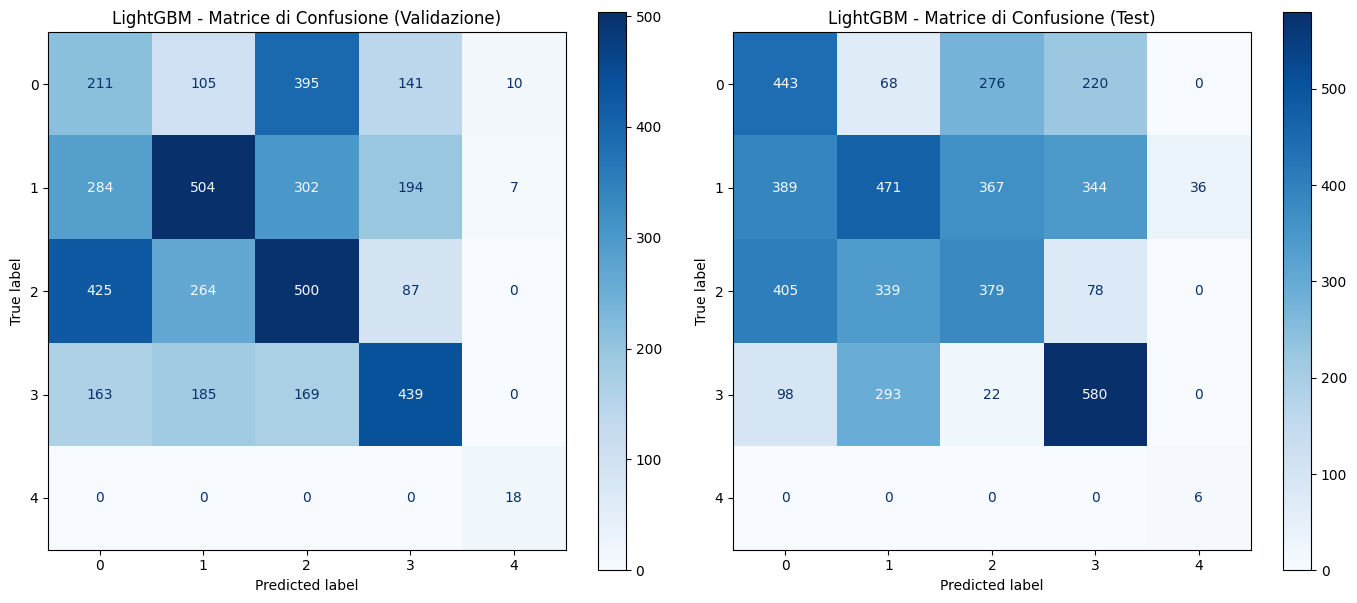

In [25]:
lightgbm_plot_confusion_matrices(lightgbm_model, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

## Esperimento 2

Esperimento effettuato prendendo come riferimento alcune features numeriche da “BirdNet”

In [26]:
csv_file_path_exp1 = 'C:/underwater-classification/resample_experiments/resampling_192000/binary/BirdNet_resampled_192000_binary.csv'


In [27]:
resample_dataset(csv_file_path_exp1, 192000)

In [28]:
#df_exp1 = exp1.extract_features_from_directory(csv_file_path_exp1)
###

In [29]:
df_exp1 = pd.read_csv(csv_file_path_exp1)

In [30]:
df_exp1.to_csv("BirdNet_resampled_192000_multi.csv", index=False)

In [31]:
df_exp1['File Name'] = df_exp1['File Name'].str[:-4]
df_exp1 = df_exp1[df_exp1['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df_exp1['Parent'] = df_exp1['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df_exp1.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp1 = df_exp1[df_exp1['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp1.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


In [32]:
X_train_imputed_exp1, X_val_imputed_exp1, X_test_imputed_exp1, y_train_encoded_exp1, y_val_encoded_exp1, y_test_encoded_exp1, subclass_encoder_exp1 = split_dataset(df_exp1)
X_train_resampled_exp1, y_train_resampled_exp1 = apply_smote_multiclass(X_train_imputed_exp1, y_train_encoded_exp1, 1)


Dimensione del set di addestramento: 33872 campioni (78.61%)
Dimensione del set di validazione: 4403 campioni (10.22%)
Dimensione del set di test: 4814 campioni (11.17%)

Distribuzione delle subclass nel set di addestramento:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64
Distribuzione delle classi nel set di training dopo SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


In [33]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp1 = X_val_imputed_exp1.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed_exp1 = X_test_imputed_exp1.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')

### 2.1 Random Forest Model

In [34]:
random_forest_model_exp1 = train_random_forest_multiclass(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Accuratezza sul Validation Set: 0.5074
Log Loss sul Validation Set: 1.1898

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.39      0.44      0.41       862
           1       0.54      0.36      0.44      1291
           2       0.54      0.70      0.61      1276
           3       0.54      0.50      0.52       956
           4       0.50      1.00      0.67        18

    accuracy                           0.51      4403
   macro avg       0.50      0.60      0.53      4403
weighted avg       0.51      0.51      0.50      4403

Accuratezza sul Test Set: 0.5293
Log Loss sul Test Set: 1.1511

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.56      0.36      0.44      1007
           1       0.51      0.42      0.46      1607
           2       0.54      0.58      0.56      1201
           3       0.53      0.81      0.64       993
    

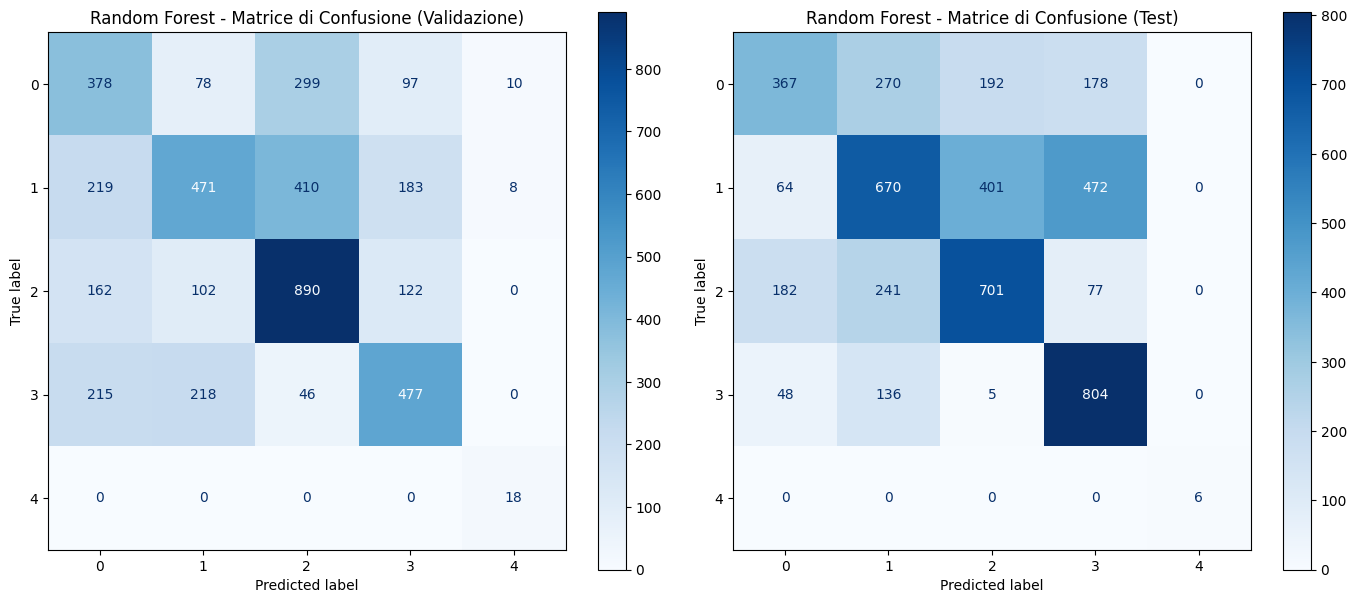

In [35]:
rf_plot_confusion_matrices(random_forest_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

### 2.2 SVM Model

In [55]:
svm_model_exp1 = train_svm_multiclass(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Distribuzione delle classi reali nel set di validazione: [ 862 1291 1276  956   18]
Distribuzione delle classi predette nel set di validazione: [ 554  457  962 2295  135]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.23      0.15      0.18       862
           1       0.35      0.12      0.18      1291
           2       0.52      0.40      0.45      1276
           3       0.33      0.80      0.47       956
           4       0.13      1.00      0.24        18

    accuracy                           0.36      4403
   macro avg       0.31      0.49      0.30      4403
weighted avg       0.37      0.36      0.32      4403

Accuratezza sul set di validazione: 0.3573
Distribuzione delle classi reali nel set di test: [1007 1607 1201  993    6]
Distribuzione delle classi predette nel set di test: [ 494  855 1174 2103  188]
Report di classificazione del set di test:
              precision    recall  f1-score   s

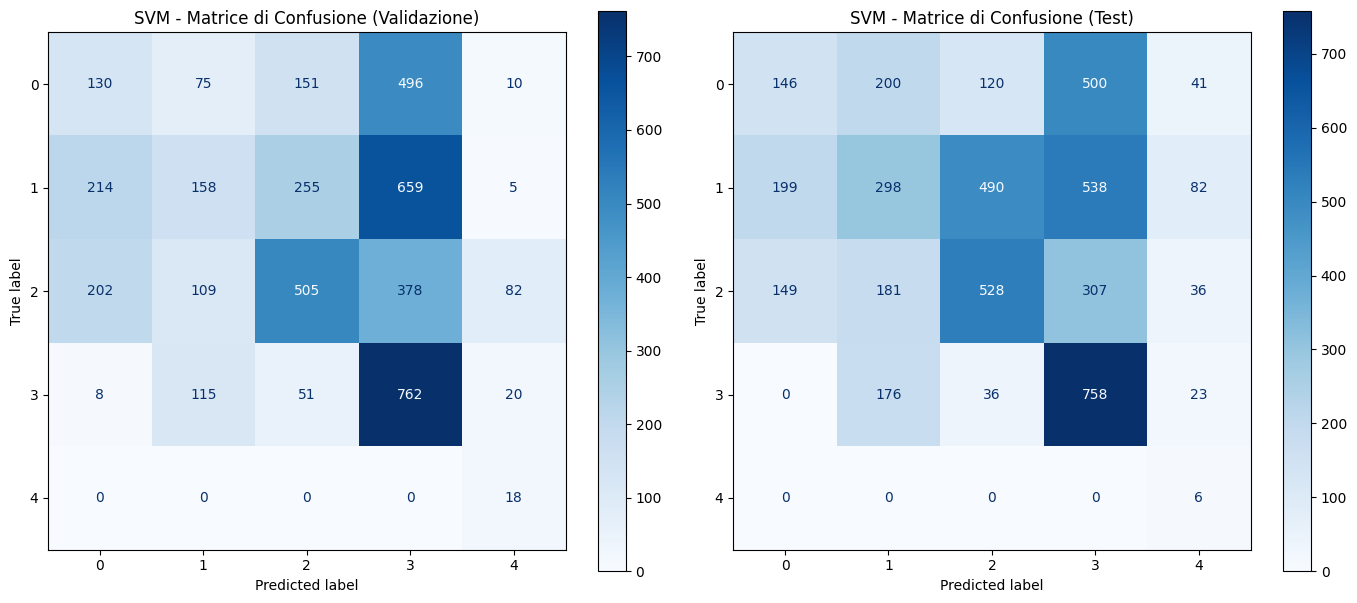

In [56]:
svm_plot_confusion_matrices(svm_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

### 2.3 LightGBM Model

In [38]:
lightgbm_model_exp1 = train_lightgbm(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Dimensioni dopo NaN nel set di addestramento: X_train: (44150, 28), y_train: (44150,)
Dimensioni dopo NaN nel set di validazione: X_val: (4403, 28), y_val: (4403,)
Dimensioni dopo NaN nel set di test: X_test: (4814, 28), y_test: (4814,)
Classi nel set di addestramento: [0 1 2 3 4]
Classi nel set di validazione: [0 1 2 3 4]
Classi nel set di test: [0 1 2 3 4]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.36      0.49      0.41       862
           1       0.51      0.41      0.45      1291
           2       0.51      0.61      0.55      1276
           3       0.67      0.43      0.53       956
           4       0.51      1.00      0.68        18

    accuracy                           0.49      4403
   macro avg       0.51      0.59      0.52      4403
weighted avg       0.51      0.49      0.49      4403

Accuratezza sul set di validazione: 0.4897
Report di classificazione del set di test:
              

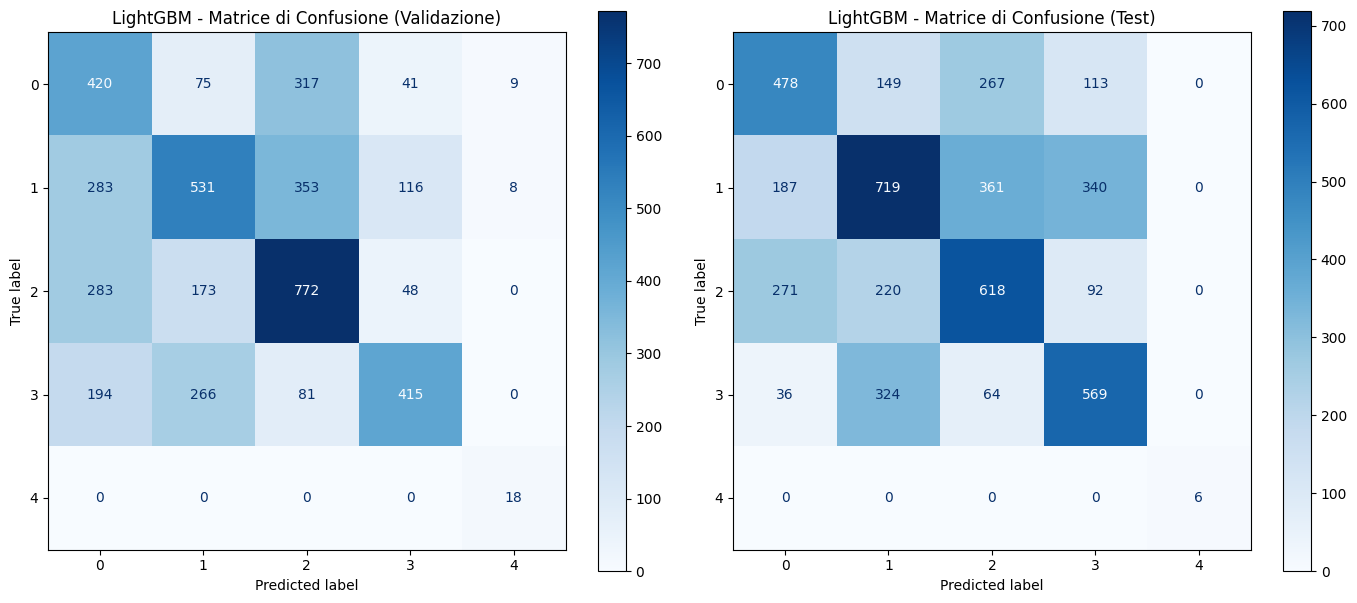

In [39]:
lightgbm_plot_confusion_matrices(lightgbm_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

## Esperimento 3

Esperimento effettuato prendendo come riferimento features numeriche da "A Survey on Audio Feature Extraction for Automatic Music Genre Classification" di Dhamodaran et al.

In [40]:
csv_file_path_exp2 = 'C:/underwater-classification/resample_experiments/resampling_192000/binary/Dhamodaran_resampled_192000_binary.csv'

In [41]:
resample_dataset(csv_file_path_exp2, 192000)

In [42]:
#df_exp2 = exp2.extract_features_from_directory(csv_file_path_exp2)

In [43]:
df_exp2 = pd.read_csv(csv_file_path_exp2)

In [44]:
df_exp2.to_csv("Dhamodaran_resampled_192000_multi.csv", index=False)

In [45]:
df_exp2['File Name'] = df_exp2['File Name'].str[:-4]
df_exp2 = df_exp2[df_exp2['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df_exp2['Parent'] = df_exp2['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df_exp2.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp2 = df_exp2[df_exp2['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp2.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


In [46]:
X_train_imputed_exp2, X_val_imputed_exp2, X_test_imputed_exp2, y_train_encoded_exp2, y_val_encoded_exp2, y_test_encoded_exp2, subclass_encoder_exp2 = split_dataset(df_exp2)
X_train_resampled_exp2, y_train_resampled_exp2 = apply_smote_multiclass(X_train_imputed_exp2, y_train_encoded_exp2, 1)

# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp2 = X_val_imputed_exp2.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed_exp2 = X_test_imputed_exp2.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')


Dimensione del set di addestramento: 33872 campioni (78.61%)
Dimensione del set di validazione: 4403 campioni (10.22%)
Dimensione del set di test: 4814 campioni (11.17%)

Distribuzione delle subclass nel set di addestramento:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64
Distribuzione delle classi nel set di training dopo SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


### 3.1 Random Forest Model

In [47]:
random_forest_model_exp2 = train_random_forest_multiclass(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Accuratezza sul Validation Set: 0.5124
Log Loss sul Validation Set: 1.1985

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.42      0.46      0.44       862
           1       0.54      0.36      0.43      1291
           2       0.53      0.68      0.59      1276
           3       0.57      0.53      0.55       956
           4       0.44      1.00      0.61        18

    accuracy                           0.51      4403
   macro avg       0.50      0.61      0.52      4403
weighted avg       0.52      0.51      0.51      4403

Accuratezza sul Test Set: 0.5154
Log Loss sul Test Set: 1.1425

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.54      0.35      0.43      1007
           1       0.49      0.40      0.44      1607
           2       0.50      0.56      0.53      1201
           3       0.53      0.81      0.64       993
    

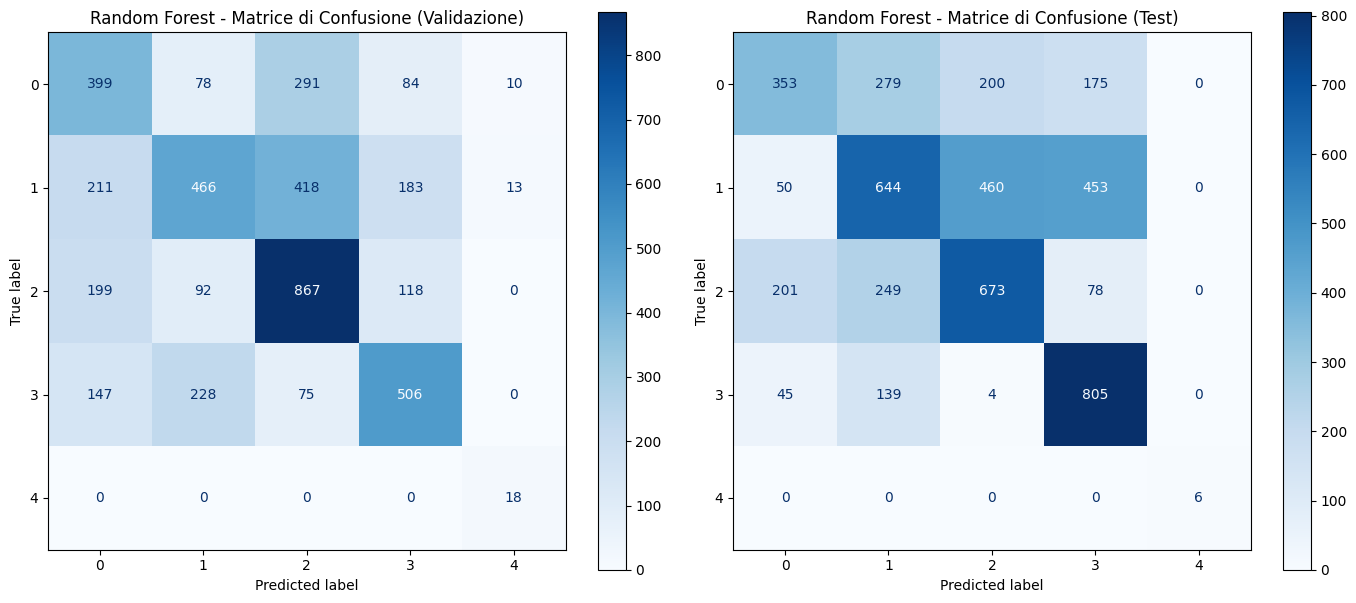

In [48]:
rf_plot_confusion_matrices(random_forest_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

### 3.2 SVM Model

In [57]:
svm_model_exp2 = train_svm_multiclass(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Distribuzione delle classi reali nel set di validazione: [ 862 1291 1276  956   18]
Distribuzione delle classi predette nel set di validazione: [1039  432 1433 1461   38]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.36      0.44      0.40       862
           1       0.48      0.16      0.24      1291
           2       0.56      0.63      0.60      1276
           3       0.49      0.75      0.59       956
           4       0.47      1.00      0.64        18

    accuracy                           0.48      4403
   macro avg       0.48      0.60      0.49      4403
weighted avg       0.48      0.48      0.45      4403

Accuratezza sul set di validazione: 0.4840
Distribuzione delle classi reali nel set di test: [1007 1607 1201  993    6]
Distribuzione delle classi predette nel set di test: [ 717  964 1459 1662   12]
Report di classificazione del set di test:
              precision    recall  f1-score   s

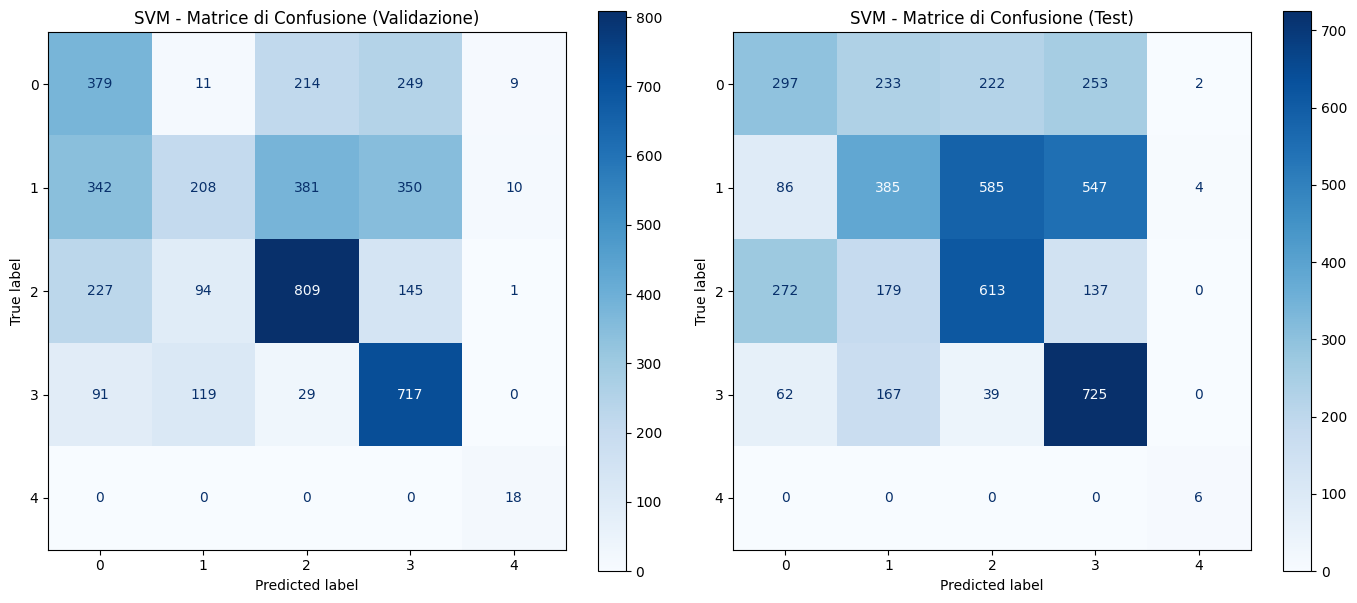

In [58]:
svm_plot_confusion_matrices(svm_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

### 3.3 LightGBM Model

In [59]:
lightgbm_model_exp2 = train_lightgbm(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Dimensioni dopo NaN nel set di addestramento: X_train: (44150, 34), y_train: (44150,)
Dimensioni dopo NaN nel set di validazione: X_val: (4403, 34), y_val: (4403,)
Dimensioni dopo NaN nel set di test: X_test: (4814, 34), y_test: (4814,)
Classi nel set di addestramento: [0 1 2 3 4]
Classi nel set di validazione: [0 1 2 3 4]
Classi nel set di test: [0 1 2 3 4]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.38      0.51      0.44       862
           1       0.52      0.42      0.47      1291
           2       0.53      0.65      0.58      1276
           3       0.70      0.45      0.55       956
           4       0.51      1.00      0.68        18

    accuracy                           0.51      4403
   macro avg       0.53      0.61      0.54      4403
weighted avg       0.54      0.51      0.51      4403

Accuratezza sul set di validazione: 0.5126
Report di classificazione del set di test:
              

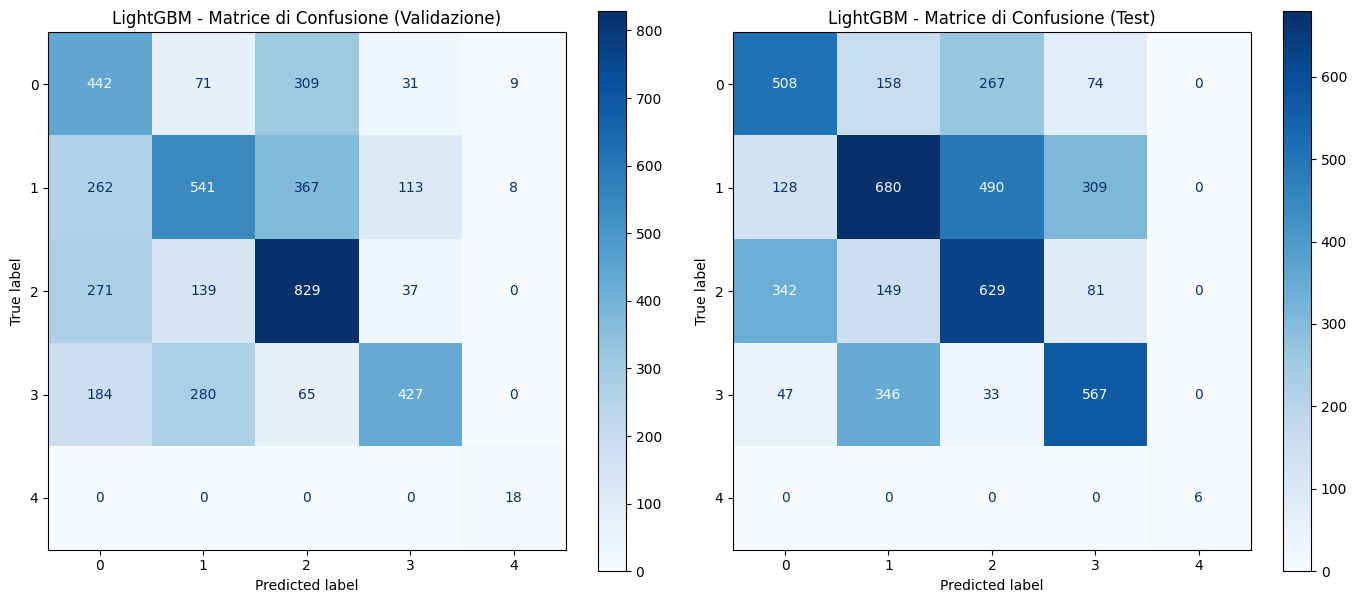

In [52]:
lightgbm_plot_confusion_matrices(lightgbm_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)